In [1]:
!pip install .

Processing /Users/Cecilia/Desktop/STA 663/project/STA-663-Final-Project/fastfsr


In [9]:
!pip install tqdm

In [10]:
!pip install progress

In [11]:
import fastfsr

In [12]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time
from tqdm import *
from progress.bar import Bar

We followed the simulation mentioned in the paper for model selection in linear regression. There are two 150 $\times$ 21 design matrices used as input data. The first set was generated independently with $\rho = 0$ from $N$(0, 1) and the second set was autocorrelated, AR(1) with $\rho$ = 0.7. In addition to the 21 original variables, the squared of the 21 variables and their pairwise interactions were also added. Hence the number of total variables is $k_T$ = 252. The added variables all have true coefficients equal to 0. 

The responses were generated from 5 models with the following labels: H0: all $\beta$s = 0; H1: $\beta_7$=1, $\beta_14$=1; H2: $\beta_6$6=9, $\beta_7$=4, $\beta_8$=1, $\beta_13$=9, $\beta_14$=4, $\beta_15$=1; H3:  $\beta_5$=25,  $\beta_6$=16,  $\beta_7$=9,  $\beta_8$=4,  $\beta_9$=1, $\beta_{12}$=25,  $\beta_{13}$=16,  $\beta_{14}$=9,  $\beta_{15}$=4,  $\beta_{16}$=1; H4: $\beta_4$=49,  $\beta_5$ = 36, $\beta_6$=25,  $\beta_7$=16,  $\beta_8$=9,  $\beta_9$=4,  $\beta_{10}$=1, $\beta_{11}$=49,$\beta_{12}$=36,  $\beta_{13}$=25,  $\beta_{14}$=16,  $\beta_{15}$=9,  $\beta_{16}$=4,  $\beta_{17}$=1. The coefficients were standardized to achieve a theoretical $R^2$=0.35. With the known `true model', we can test the accuracy of the models on this simulated data set. The authors posted their simulated data sets publicly online and we used the same data set to check our results.

We used several measures to compare the performance among Fast FSR, BIC, and LASSO. These measures include: (1) size: average model size. (2)ME: average model error = $ (1/n)|\hat{Y}- \mu|^2$. (3)FSR: average false selection rate = average of (number of unimportant variables selected)$/$(1+ number of total variables selected), and a lower value is preferred. (4) MSE: average error mean square of the chosen model and close to $\sigma^2$ suggests selection method is tuned. (5) CSR: the average proportion of correctly chosen variables, and a lower value is preferred. (6) JAC: Jaccard's measure that combines FSR and CSR in a particular way, and a lower value is preferred. The Monte Carlo standard errors of the above measures were calculated as well. 

In [13]:
url1 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/x.quad.0.txt'
url2 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/x.quad.70.txt'
url3 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h0_0.rs35.txt'
url4 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h1_0.rs35.txt'
url5 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h2_0.rs35.txt'
url6 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h3_0.rs35.txt'
url7 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h4_0.rs35.txt'
url8 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h0_70.rs35.txt'
url9 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h1_70.rs35.txt'
url10 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h2_70.rs35.txt'
url11 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h3_70.rs35.txt'
url12 = 'http://www4.stat.ncsu.edu/~boos/var.select/sim/h4_70.rs35.txt'

# 0 - 20: indepedent standard normal
# 21 - 41: squares
# 42 - 251: pairwise interactions
x1 = pd.read_csv(url1, header = None, delim_whitespace = True)
x2 = pd.read_csv(url2, header = None, delim_whitespace = True)

# response
y1_h0 = pd.read_csv(url3, delim_whitespace = True)
y1_h1 = pd.read_csv(url4, delim_whitespace = True)
y1_h2 = pd.read_csv(url5, delim_whitespace = True)
y1_h3 = pd.read_csv(url6, delim_whitespace = True)
y1_h4 = pd.read_csv(url7, delim_whitespace = True)

y2_h0 = pd.read_csv(url8, delim_whitespace = True)
y2_h1 = pd.read_csv(url9, delim_whitespace = True)
y2_h2 = pd.read_csv(url10, delim_whitespace = True)
y2_h3 = pd.read_csv(url11, delim_whitespace = True)
y2_h4 = pd.read_csv(url12, delim_whitespace = True)

In [14]:
# simulation
x1_matrix = x1.ix[:,0:20]
x2_matrix = x2.ix[:,0:20]
hbeta = np.zeros((5, 14))

# true betas for five models
hbeta[0,:] = np.repeat(-1, 14)
hbeta[1,:] = np.concatenate([np.array([6, 13]), np.repeat(-1, 12)])
hbeta[2,:] = np.concatenate([np.array([5, 6, 7, 12, 13, 14]), np.repeat(-1, 8)])
hbeta[3,:] = np.concatenate([np.array([4, 5, 6, 7, 8, 11, 12, 13, 14, 15]), np.repeat(-1, 4)])
hbeta[4,:] = np.array([3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16])

In [15]:
def simulation(x, y, model):
    """function that can perform simulation for all three models"""
    res = np.zeros((5, 14))
    me_out = np.zeros((100, 4))
    me_out1_21 = np.zeros((100, 4, 5))
    me_out2_21 = np.zeros((100, 4, 5))
    jac = np.zeros(100)
    data = y
    for m in range(5):
        hdata = data[m]
        hdata_y = np.array(hdata.ix[:,2]).reshape([100, 150])
        mu = hdata.ix[0:149,1]                                     # true means
        beta = hbeta[m,:]
        
        for i in tqdm(range(100)):
            out_bic = model(x, hdata_y[i,:])
            size = out_bic['size']                                 # number of fitted x's
            correct = len(np.intersect1d(out_bic['index'], beta))  # number correct
            false = size - correct                                 # number false
            me_out[i, 0] = np.mean((out_bic['fitted'] - mu)**2)    # model error
            me_out[i, 1] = size
            me_out[i, 2] = false
            me_out[i, 3] = out_bic['residual']/out_bic['df_residual']
        
        me_out1_21[:,:,1] = np.round(me_out, 4)
        model_size = sum(beta != -1)                               # true model size
     
        for i in range(100):
            if me_out[i, 2] + model_size > 0:
                jac[i] = (me_out[i, 1] - me_out[i, 2])/(me_out[i, 2] + model_size)
            else:
                jac[i] = 1
        res[m, 0] = 0                                              # rho
        res[m, 1] = m                                              # model h0, h1
        res[m, 2] = np.mean(me_out[:,1])                           # model size
        res[m, 3] = np.std(me_out[:,1]/10)                         # se of the mean
        res[m, 4] = np.mean(me_out[:,0])                           # me
        res[m, 5] = np.std(me_out[:,0])/10
        res[m, 6] = np.mean(me_out[:,2]/(1 + me_out[:,1]))         # fsr
        res[m, 7] = np.std(me_out[:,2]/(1 + me_out[:,1]))/10
        res[m, 8] = np.mean(me_out[:,3])                           # mse of selected model
        res[m, 9] = np.std(me_out[:,3])/10
        if model_size > 0:
            csr = (me_out[:,1] - me_out[:,2])/model_size
        else:
            csr = np.ones(100)
        res[m, 10] = np.mean(csr)
        res[m, 11] = np.std(csr)/10
        res[m, 12] = np.mean(jac)
        res[m, 13] = np.std(jac)/10
    return np.round(pd.DataFrame({'rho': res[:,0], 'H': res[:,1], 'size': res[:,2], 'me': res[:,4], 
                     'fsr_mr': res[:,6], 'mse': res[:,8], 'csr': res[:,10], 'jac': res[:,12],
                     'se_size': res[:,3], 'se_me': res[:,5], 'se_fsr': res[:,7], 'se_mse': res[:,9],
                     'se_csr': res[:,11], 'se_jac': res[:,13]}), 3)

## Fast FSR

In [18]:
res_fsr1 = simulation(x1_matrix, [y1_h0, y1_h1, y1_h2, y1_h3, y1_h4], fastfsr.fsr_fast)
res_fsr1

100%|██████████| 100/100 [00:30<00:00,  3.59it/s]


,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.062,0.880,0.015,0.975,0.0,0.000,0.017,0.032,0.003,0.011,0.042,0.14
1,1.0,1.000,0.048,0.937,0.031,1.000,0.0,0.000,0.011,0.014,0.003,0.013,0.050,2.21
2,2.0,0.537,0.055,0.512,0.089,0.988,0.0,0.014,0.010,0.014,0.005,0.011,0.115,3.54
3,3.0,0.424,0.050,0.408,0.132,1.016,0.0,0.012,0.009,0.011,0.007,0.012,0.164,4.61
4,4.0,0.409,0.033,0.401,0.155,1.021,0.0,0.010,0.006,0.010,0.006,0.013,0.161,5.99


In [19]:
res_fsr2 = simulation(x2_matrix, [y2_h0, y2_h1, y2_h2, y2_h3, y2_h4], fastfsr.fsr_fast)
res_fsr2

100%|██████████| 100/100 [00:29<00:00,  3.34it/s]


,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.047,0.910,0.011,1.009,0.0,0.000,0.015,0.029,0.002,0.010,0.033,0.10
1,1.0,0.985,0.053,0.921,0.036,0.999,0.0,0.009,0.011,0.017,0.004,0.013,0.050,2.19
2,2.0,0.363,0.070,0.348,0.075,0.987,0.0,0.007,0.012,0.007,0.004,0.011,0.066,2.48
3,3.0,0.244,0.041,0.240,0.114,1.014,0.0,0.007,0.009,0.007,0.004,0.012,0.078,2.62
4,4.0,0.210,0.038,0.208,0.124,1.014,0.0,0.007,0.009,0.007,0.004,0.013,0.099,3.12


In addition to Fast FSR, we also ran  BIC and LASSO on the data sets and compared the results of the three models. In the originally paper, the authors used the R package leaps for best subset selection. However, there does not exist corresponding package or function in Python and hence we also implemented a regression subset selection. The other method LASSO and cross validation was computed with the package scikit-learn.

## BIC

In [20]:
res_bic1 = simulation(x1_matrix, [y1_h0, y1_h1, y1_h2, y1_h3, y1_h4], fastfsr.bic_sim)
res_bic1

100%|██████████| 100/100 [00:22<00:00,  4.11it/s]


,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.243,0.560,0.033,0.960,0.0,0.000,0.028,0.050,0.004,0.012,0.088,0.62
1,1.0,1.000,0.132,0.829,0.045,0.989,0.0,0.000,0.015,0.020,0.003,0.013,0.072,2.58
2,2.0,0.572,0.091,0.532,0.088,0.975,0.0,0.013,0.012,0.014,0.005,0.011,0.106,3.95
3,3.0,0.449,0.065,0.431,0.123,1.005,0.0,0.010,0.009,0.010,0.006,0.011,0.128,4.94
4,4.0,0.419,0.036,0.411,0.153,1.016,0.0,0.009,0.007,0.009,0.006,0.013,0.139,6.15


In [21]:
res_bic2 = simulation(x2_matrix, [y2_h0, y2_h1, y2_h2, y2_h3, y2_h4], fastfsr.bic_sim)
res_bic2

100%|██████████| 100/100 [00:22<00:00,  4.48it/s]


,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.208,0.640,0.029,0.995,0.0,0.000,0.028,0.048,0.003,0.010,0.084,0.55
1,1.0,0.990,0.109,0.854,0.044,0.991,0.0,0.007,0.015,0.020,0.004,0.013,0.068,2.45
2,2.0,0.402,0.128,0.373,0.080,0.971,0.0,0.010,0.014,0.011,0.004,0.011,0.073,2.98
3,3.0,0.277,0.067,0.270,0.109,0.999,0.0,0.008,0.011,0.008,0.004,0.012,0.091,3.09
4,4.0,0.241,0.055,0.237,0.112,0.997,0.0,0.007,0.010,0.007,0.004,0.012,0.102,3.66


## LASSO

In [22]:
res_lasso1 = simulation(x1_matrix, [y1_h0, y1_h1, y1_h2, y1_h3, y1_h4], fastfsr.lasso_fit)
res_lasso1

100%|██████████| 100/100 [00:01<00:00, 84.61it/s]


,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.690,0.000,0.016,0.973,0.0,0.000,0.014,0.000,0.002,0.011,0.379,3.45
1,1.0,1.000,0.422,0.489,0.064,1.035,0.0,0.000,0.016,0.017,0.003,0.013,0.143,4.55
2,2.0,0.697,0.269,0.531,0.105,1.039,0.0,0.012,0.012,0.013,0.004,0.011,0.132,6.22
3,3.0,0.580,0.175,0.506,0.139,1.088,0.0,0.011,0.012,0.011,0.005,0.011,0.157,7.38
4,4.0,0.537,0.083,0.507,0.178,1.126,0.0,0.010,0.008,0.009,0.005,0.013,0.168,8.37


In [23]:
res_lasso2 = simulation(x2_matrix, [y2_h0, y2_h1, y2_h2, y2_h3, y2_h4], fastfsr.lasso_fit)
res_lasso2

100%|██████████| 100/100 [00:01<00:00, 79.37it/s]


,H,csr,fsr_mr,jac,me,mse,rho,se_csr,se_fsr,se_jac,se_me,se_mse,se_size,size
0,0.0,1.000,0.675,0.000,0.017,1.009,0.0,0.000,0.014,0.000,0.002,0.010,0.479,3.79
1,1.0,1.000,0.420,0.490,0.058,1.035,0.0,0.000,0.016,0.017,0.004,0.013,0.142,4.53
2,2.0,0.662,0.271,0.509,0.064,1.006,0.0,0.015,0.016,0.016,0.003,0.011,0.167,6.06
3,3.0,0.578,0.167,0.510,0.077,1.028,0.0,0.011,0.012,0.011,0.003,0.011,0.151,7.26
4,4.0,0.500,0.107,0.467,0.079,1.035,0.0,0.010,0.009,0.009,0.003,0.012,0.167,8.02


## Model Comparison

####  False Selection Rate

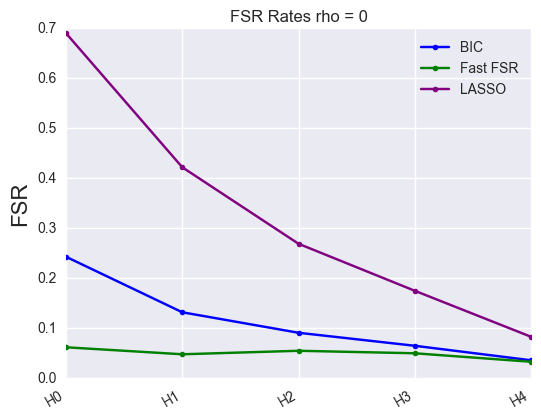

In [25]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic1['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr1['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso1['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='upper right')
ax.set_ylabel('FSR', fontsize = 16)
ax.set_title('FSR Rates rho = 0')
plt.xticks(xlabel, xlabel_name)
pass

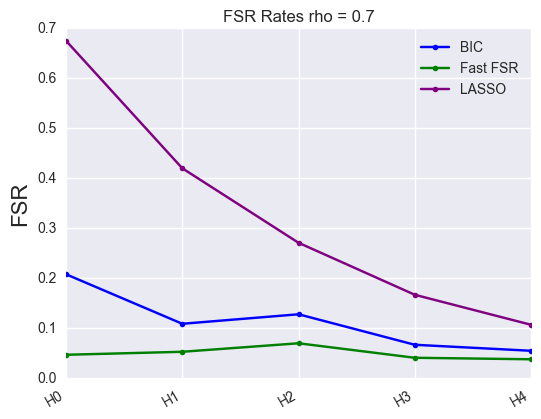

In [26]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic2['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr2['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso2['fsr_mr'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='upper right')
ax.set_ylabel('FSR', fontsize = 16)
ax.set_title('FSR Rates rho = 0.7')
plt.xticks(xlabel, xlabel_name)
pass

#### Correct Selection Rate

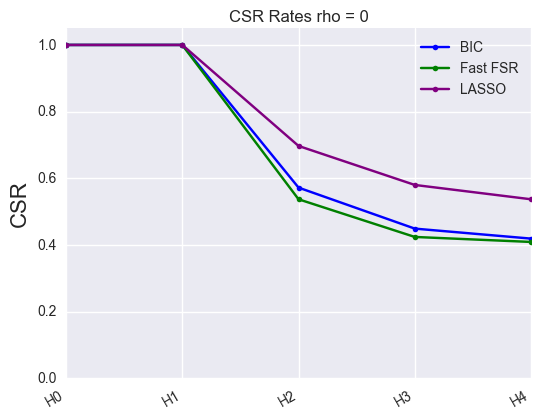

In [27]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic1['csr'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr1['csr'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso1['csr'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='upper right')
ax.set_ylabel('CSR', fontsize = 16)
ax.set_title('CSR Rates rho = 0')
plt.xticks(xlabel, xlabel_name)
plt.ylim([0,1.05])
pass


#### Average Model Size

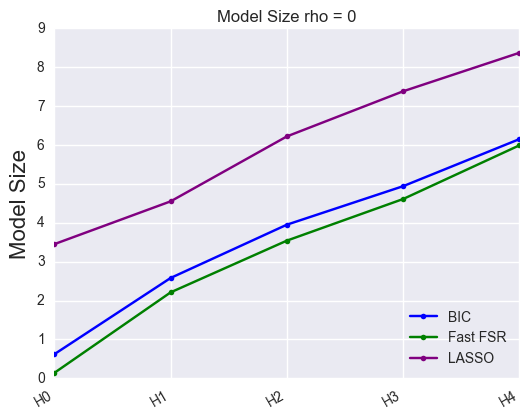

In [28]:
xlabel = [1, 2, 3, 4, 5]
xlabel_name = ['H0', 'H1', 'H2', 'H3', 'H4']

fig, ax = plt.subplots(figsize = (6, 5)) 
fig.autofmt_xdate()
plt.plot(xlabel, res_bic1['size'], marker = 'o', markersize = 4, 
         color = 'blue', linestyle = 'solid',
         label = 'BIC')

plt.plot(xlabel, res_fsr1['size'], marker = 'o', markersize = 4, 
         color = 'green', linestyle = 'solid',
         label = 'Fast FSR')

plt.plot(xlabel, res_lasso1['size'], marker = 'o', markersize = 4, 
         color = 'purple', linestyle = 'solid',
         label = 'LASSO')

plt.legend(loc='lower right')
ax.set_ylabel('Model Size', fontsize = 16)
ax.set_title('Model Size rho = 0')
plt.xticks(xlabel, xlabel_name)
pass

As can be seen, Fast FSR leads to a small and stable FSR across all 5 models, and is close to the advertised 0.05 FSR. The other two methods BIC and LASSO have much larger FSR. It is also noted that the FSR for BIC and LASSO decreases as the number of nonzero $\beta$s in the model increases. CSR is complementary to FSR, and together with the model size provides a full picture of the  model selection characteristics of the each method.

As can be seen, Fast FSR leads to a small and stable FSR across all 5 models, and is close to the advertised 0.05 FSR. The other two methods BIC and LASSO have much larger FSR. It is also noted that the FSR for BIC and LASSO decreases as the number of nonzero $\beta$s in the model increases. CSR is complementary to FSR, and together with the model size provides a full picture of the  model selection characteristics of the each method.